In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import cm
import pylab as pl

In [2]:
# COMMON FUNCTION
def extractdata(classification, testfile):
    """ extrac the trainning data end test data given the path
    to these files"""
    train  = pd.read_table(classification, header=None, engine='python')
    test = pd.read_table(testfile, header=None, engine='python')
    X_train, X_test = train.as_matrix()[:,0:2], test.as_matrix()[:,0:2]
    y_train, y_test = train.as_matrix()[:,2], test.as_matrix()[:,2]
    return X_train, y_train, X_test, y_test

def f(x, y, C, w, b):
    return (C[0,0]*x**2 + 2 * C[0,1]*x*y + C[1,1]*y**2 + w[0] * x + w[1] * y + b)

def sigmoid(x):
    return 1/(1 + math.exp(-x))

def decision(y):
    n = len(y)
    res = y
    for k in range(n):
        if y[k] > 0.5 :
            res[k] = 1
        else :
            res[k] = 0
    return res 

symlist = ['o', 's']
def plot_2D(data, y, w, b = None,  C = None, name= None ):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""
    fig = plt.figure()
    color_blind_list = sns.color_palette("colorblind", 2)
    sns.set_palette(color_blind_list)
    labs = [0,1]
    idxbyclass = [np.where(y == labs[i])[0] for i in range(2)]

    for i in range(2):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=color_blind_list[i], s=80, marker=symlist[i])
    
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    my = np.min(data[:, 0])
    maxy = np.max(data[:, 0])
    
    if C is not None:
        x = np.linspace(mx, maxx, 400)
        y = np.linspace(my, maxy, 400)
        x, y = np.meshgrid(x, y)

        plt.contour(x, y, f(x, y, C, w, b), [0], colors='k')
        if name is not None:
            fig.savefig(name)
    else :
        plt.plot([mx, maxx], [- mx * w[0] / w[1] - w[2] / w[1],
                              - maxx * w[0] / w[1] - w[2] / w[1]])
        if name is not None:
            fig.savefig(name)
        

#LDA FUNCTIONS      
        
def trainLDA(X_tr, y_tr):
    """ takes the trainning data, estimates sigma, m0, m1 and returns
    w,b and pi, the coefficient neede to derivate the conditional probability"""
    m1 = np.mean(X_tr[np.where(y_tr==1)],axis=0)
    m0 = np.mean(X_tr[np.where(y_tr==0)],axis=0)
    n = np.shape(X_tr)[0]
    sigma = np.zeros((2,2))
    
    k1, k0 = np.shape(X_tr[np.where(y_tr==1)])[0], np.shape(X_tr[np.where(y_tr==0)])[0]
    for k in range(k1):
        tmp = np.reshape(X_tr[np.where(y_tr==1)][k] - m1,(2,1))
        sigma += np.dot(tmp,tmp.T)
    for k in range(k0):
        tmp = np.reshape(X_tr[np.where(y_tr==0)][k] - m0,(2,1))
        sigma += np.dot(tmp,tmp.T)
   
    sigma = sigma/n
    A = np.linalg.inv(sigma) 
    w = np.dot(A, m1-m0)
    pi = float(k1)/n
    b = (np.dot(m0,np.dot(A,m0))-np.dot(m1,np.dot(A,m1)))/2 - math.log((1-pi)/pi)
    return w,b,pi

def testSigmo(X_t,w,b, C = None):
    """compute the conditional expactation of y given X_t, returns y """
    if C is not None:
        #case of the QDA
        y = [sigmoid(f(X_t[k,0], X_t[k,1], C, w, b)) for k in range(np.shape(X_t)[0])]
    else :
        #case of logistic regression or LDA
        y = [sigmoid(np.dot(X_t[k],w)+b) for k in range(np.shape(X_t)[0])]
    return y 

#logistic regression

def gradcompute(X_tr,y_tr, w):
    """compute the gradient and the hassian of the log likelyhood in w for a given X_tr, y_tr """
    n = np.shape(X_tr)[0]
    cst = np.ones(n)
    Xe = np.c_[X_tr,cst]
    eta = np.array([sigmoid(np.dot(Xe[k],w)) for k in range(n)])
    grad = np.dot(Xe.T,np.reshape((y_tr-eta),(n,1)))
    diag = np.array([eta[k]*(1-eta[k]) for k in range (n)])
    diag = np.diag(diag)
    H = np.dot(- Xe.T, np.dot(diag,Xe))
    
    return grad, H
    
def IRLS(X_tr, y_tr, init, epsilon):
    """IRLS algo. use the newton method. init is the initial point w, epsilon is the stopping criterion """
    w = init
    g, H = gradcompute(X_tr,y_tr, w)
    while (np.linalg.norm(g) > epsilon):
        w = w - np.ravel(np.dot(np.linalg.inv(H),g))
        g, H = gradcompute(X_tr,y_tr, w)
    return w

#linear regression

def trainLR(X_tr,y_tr):
    """ takes the trainning data , 
    returns the parameters w and b of the linear model y = w^T x + b"""
    n,p = np.shape(X_tr)
    ones = np.ones((n,1))
    # X_aug = np.hstack((X_tr,ones))  "Made to compute w and b in a single vector"
    X_aug = np.c_[X_tr,ones]
    #A = np.linalg.pinv(np.dot(X_aug.T,X_aug)) 
    M = np.dot(X_aug.T,X_aug)
    #w_aug = np.dot(A,np.dot(X_aug.T,y_tr))
    b = np.dot(X_aug.T,y_tr)
    w_aug = np.linalg.solve(M,b)
    print(w_aug)
    w, b = w_aug[0:p], w_aug[p]
    return w,b

def linear(x,w,b):
    return np.dot(x,w) + b
def testLR(X_test,w,b):
    y = [linear(X_test[k],w,b) for k in range(np.shape(X_test)[0])]
    return y

#QDA

def trainQDA(X_tr, y_tr):
    """ takes the trainning data, estimates sigma, m0, m1 and returns
    w,b and pi, the coefficient neede to derivate the conditional probability"""
    m1 = np.mean(X_tr[np.where(y_tr==1)],axis=0)
    m0 = np.mean(X_tr[np.where(y_tr==0)],axis=0)
    n = np.shape(X_tr)[0]
    sigma0, sigma1 = np.zeros((2,2)), np.zeros((2,2))
    
    k1, k0 = np.shape(X_tr[np.where(y_tr==1)])[0], np.shape(X_tr[np.where(y_tr==0)])[0]
    for k in range(k1):
        tmp = np.reshape(X_tr[np.where(y_tr==1)][k] - m1,(2,1))
        sigma1 += np.dot(tmp,tmp.T)/k1
    for k in range(k0):
        tmp = np.reshape(X_tr[np.where(y_tr==0)][k] - m0,(2,1))
        sigma0 += np.dot(tmp,tmp.T)/k0
   
    
    return m0, m1, sigma0, sigma1

def coefDQA(m0, m1, sigma0, sigma1):
    """compute the coeficient C, w, b with m0, m1, sigma0, sigma1.
    C, w, b are used to compute the estimated conditional probability of y given x in the QDA case"""
    det0 = np.linalg.det(sigma0)
    det1 = np.linalg.det(sigma1)
    A0 = np.linalg.inv(sigma0)
    A1 = np.linalg.inv(sigma1)
    b = (np.dot(m0,np.dot(A0,m0))-np.dot(m1,np.dot(A1,m1)))/2 - math.log((1-pi)/pi) - math.log(det1/det0)/2
    w = np.dot(A1, m1) - np.dot(A0, m0)
    C = (A0 - A1)/2
    
    return C, w, b

In [3]:
filenames = [('classification_data_HWK1/classificationA.train','classification_data_HWK1/classificationA.test'),
            ('classification_data_HWK1/classificationB.train','classification_data_HWK1/classificationB.test'),
            ('classification_data_HWK1/classificationC.train','classification_data_HWK1/classificationC.test')]
figures = ["Atrain", "Btrain", "Ctrain"]
for s, names in enumerate(filenames) :
    X_train, y_train, X_test, y_test = extractdata(names[0], names[1])
    w,b,pi = trainLDA(X_train, y_train)
    print("w = ", w, "\n", "b = ", b)
    y_t = testSigmo(X_test,w,b)
    y_t = decision(y_t)
    y_tr = testSigmo(X_train,w,b)
    #print(y_tr)
    y_tr = decision(y_tr)
    #print(np.sum(y_tr), " et ",np.sum(y_train))
    errortr, errort =  np.mean(abs(y_train-y_tr)), np.mean(abs(y_test-y_t))
    print( "error over trainning set = ", errortr, "error over test set = ", errort) 
    w = np.r_[w,np.array([b])]
    name = figures[s]+"lda.png"
    plot_2D(X_train, y_train, w, name = name)

('w = ', array([-6.62245258, -9.3462503 ]), '\n', 'b = ', -0.1364962909477897)
('error over trainning set = ', 0.013333333333333334, 'error over test set = ', 0.02)
('w = ', array([-1.92108197,  0.95442836]), '\n', 'b = ', 0.00092928871654307521)
('error over trainning set = ', 0.029999999999999999, 'error over test set = ', 0.041500000000000002)
('w = ', array([-2.05129911, -0.27311529]), '\n', 'b = ', 0.11242913217698391)
('error over trainning set = ', 0.055, 'error over test set = ', 0.042333333333333334)


In [4]:
for s, names in enumerate(filenames) :
    X_train, y_train, X_test, y_test = extractdata(names[0], names[1])
    
    w = IRLS(X_train, y_train, np.array([0,0,0]), 0.001)
    print("w = ", w)
    y_t = testSigmo(X_test,w[:2],w[2])
    y_t = decision(y_t)
    y_tr = testSigmo(X_train,w[:2],w[2])
    y_tr = decision(y_tr)
    print(np.sum(y_tr), " et ",np.sum(y_train))
    errortr, errort =  np.mean(abs(y_train-y_tr)), np.mean(abs(y_test-y_t))
    print( "error over trainning set = ", errortr, "error over test set = ", errort) 
    name = figures[s]+"logreg.png"
    plot_2D(X_train, y_train, w, name = name)

('w = ', array([-182.06790875, -315.05580399,  -30.64398373]))
(50, ' et ', 50.0)
('error over trainning set = ', 0.0, 'error over test set = ', 0.034666666666666665)
('w = ', array([-1.70518566,  1.02378525,  1.3495913 ]))
(146, ' et ', 150.0)
('error over trainning set = ', 0.02, 'error over test set = ', 0.042999999999999997)
('w = ', array([-2.20323226,  0.70926552,  0.95918875]))
(252, ' et ', 250.0)
('error over trainning set = ', 0.040000000000000001, 'error over test set = ', 0.022666666666666668)


In [16]:
for s, names in enumerate(filenames) :
    X_train, y_train, X_test, y_test = extractdata(names[0], names[1])
    w,b = trainLR(X_train, y_train)
    print("w = ", w, "\n", "b = ", b)
    y_tr = testLR(X_train,w[:2], b)
    y_t = testLR(X_test,w[:2], b)
    b = b - 0.5
    y_t = decision(y_t)
    y_tr = decision(y_tr)
    print(np.sum(y_tr), " et ",np.sum(y_train))
    errortr, errort =  np.mean(abs(y_train-y_tr)), np.mean(abs(y_test-y_t))
    print( "error over trainning set = ", errortr, "error over test set = ", errort) 
    
    w = np.r_[w,np.array([b])]
    name = figures[s]+"linreg.png"
    plot_2D(X_train, y_train, w, name = name)
    


[-0.2640075  -0.37259311  0.49229204]
('w = ', array([-0.2640075 , -0.37259311]), '\n', 'b = ', 0.49229203756476358)
(52, ' et ', 50.0)
('error over trainning set = ', 0.013333333333333334, 'error over test set = ', 0.020666666666666667)
[-0.10424575  0.05179118  0.50005043]
('w = ', array([-0.10424575,  0.05179118]), '\n', 'b = ', 0.50005042699975688)
(143, ' et ', 150.0)
('error over trainning set = ', 0.029999999999999999, 'error over test set = ', 0.041500000000000002)
[-0.12769333 -0.01700142  0.50839982]
('w = ', array([-0.12769333, -0.01700142]), '\n', 'b = ', 0.50839981582634897)
(254, ' et ', 250.0)
('error over trainning set = ', 0.055, 'error over test set = ', 0.042333333333333334)


In [14]:
for s, names in enumerate(filenames) :
    X_train, y_train, X_test, y_test = extractdata(names[0], names[1])
    m0, m1, sigma0, sigma1 = trainQDA(X_train, y_train)
    C, w, b = coefDQA(m0, m1, sigma0, sigma1)
    print ( C, w, b )
    y_t = testSigmo(X_test,w, b, C)
    y_t = decision(y_t)
    y_tr = testSigmo(X_train,w, b, C)
    y_tr = decision(y_tr)
    print(np.sum(y_tr), " et ",np.sum(y_train))
    errortr, errort =  np.mean(abs(y_train-y_tr)), np.mean(abs(y_test-y_t))
    print( "error over trainning set = ", errortr, "error over test set = ", errort)
    
    name = figures[s]+"qda.png"
    plot_2D(X_train, y_train, w, b, C, name = name)
    
    

(array([[-0.7587202 , -1.51361485],
       [-1.51361485, -2.86166338]]), array([ -7.36527314, -10.87335416]), 0.57770135130777778)
(52, ' et ', 50.0)
('error over trainning set = ', 0.013333333333333334, 'error over test set = ', 0.024666666666666667)
(array([[-0.47982628, -1.92382528],
       [-1.92382528, -5.52933507]]), array([-2.28065009,  1.45700199]), 3.8773274797670663)
(147, ' et ', 150.0)
('error over trainning set = ', 0.016666666666666666, 'error over test set = ', 0.021499999999999998)
(array([[ 0.00244301, -0.14592984],
       [-0.14592984,  0.11805533]]), array([-2.66524064,  0.34888942]), 0.11004274889207422)
(253, ' et ', 250.0)
('error over trainning set = ', 0.052499999999999998, 'error over test set = ', 0.03833333333333333)


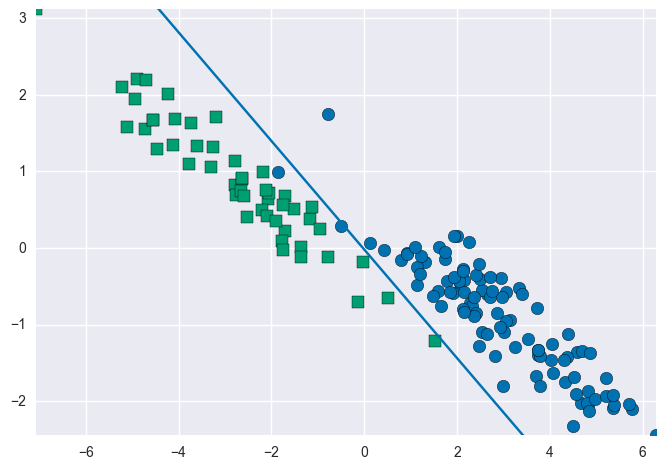

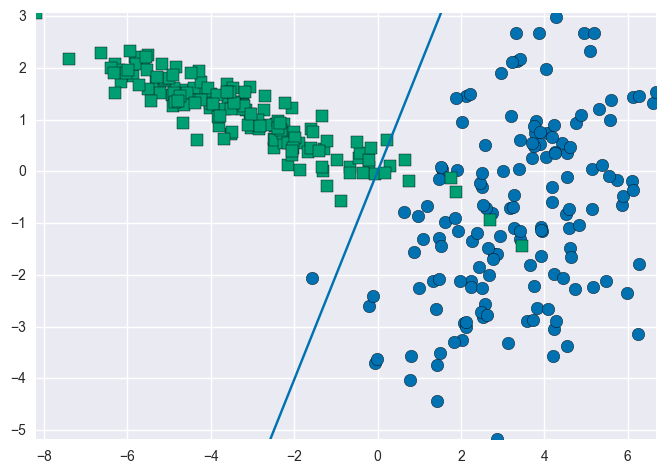

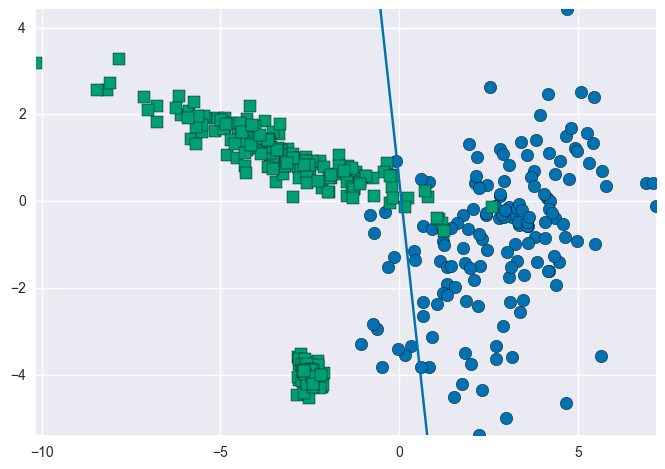

In [17]:
plt.show()